In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime
import random 
import sys
from ecological_fairness import * 
import pandas as pd
import glob
from scipy.spatial import Delaunay
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import seaborn as sns
sns.reset_orig()

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_dem_disp_obs_outcomes_multi_race_over_LCs(Y, n_as, mu_scalar, p_az,
    p_yz,  Z, LCs,ind_mu, quiet=True, smoothing=None, smoothing1d=False, direction = 'max', save = True):
    ress__ = [None] * len(LCs)
    for ind,lc in enumerate(LCs):
        ress__[ind] = get_dem_disp_obs_outcomes_multi_race(Y, n_as, mu_scalar, p_az, p_yz,  Z, lc, quiet, smoothing, smoothing1d, direction)
        pickle.dump({'res': ress__[ind], 'mu_scalar':mu_scalar}, open('out/countyincome/output-'+str(ind_mu)+'-'+'lc' + str(lc) +'-' +datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.pkl', 'wb'))
    pickle.dump({'res': ress__, 'mu_scalar':mu_scalar}, open('out/output-'+str(ind_mu)+'-'+datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.pkl', 'wb'))
    return ress__

def get_DD_multi_race_caller(Y, n_as, mu_scalar, p_az, p_yz,  Z, lc, ind, quiet=True, smoothing=None, smoothing1d=False,direction = 'max', stump = 'hmda', save = True):
    res = get_dem_disp_obs_outcomes_multi_race(Y, n_as, mu_scalar, p_az, p_yz,  Z, lc, quiet, smoothing, smoothing1d, direction)
    pickle.dump({'res': res, 'mu_scalar':mu_scalar, 'lc':lc}, open('out/'+stump+'/output-'+str(ind)+'-lc-'+str(lc)+'-'+datetime.now().strftime('%Y-%m-%d-%H-%M-%S')+'.pkl', 'wb'))
    return res


def select_name(lip, lip_list_whole, name_list):
    return [name_list[i] for i in range(len(lip_list_whole)) if (lip == lip_list_whole[i])]


def get_disps(w_y1, w_y0, n_as, y, p_as):
    n = len(y)
    return [ 1.0/n * ( np.dot(w_y1[0,:],y)/p_as[0] - np.dot(w_y1[a,:],y)/p_as[a] ) for a in range(n_as)[1:] ]


def compute_disparity_from_res(res, n_as, Y, p_as):
    if (~np.isnan(res[0])):
        return get_disps(res[1], res[2], n_as, Y, p_as)
    else:
        return [np.nan, np.nan]
    
def parse_name(directory, N_LCs):
    name_list = glob.glob(directory + "/*")
    split_name = [name.split('-') for name in name_list]
    lip_list_whole = [s[3] for s in split_name]
    lip_list = lip_list_whole[0:N_LCs]
    return lip_list, lip_list_whole, name_list

def compile_disparity(lip_list, lip_list_whole, name_list, n_as, Y, p_as):
    dd = {lip:None for lip in lip_list}
    for lip in lip_list:
        print lip 
        files = select_name(lip, lip_list_whole, name_list)
        disparity = np.zeros((len(files), 2))
        for ind in range(len(files)):
            disps_temp = pickle.load(open(files[ind],'rb')) 
            mu_scalar = disps_temp['mu_scalar']
            res = disps_temp['res']
            disparity[ind, :] = compute_disparity_from_res(res, n_as, Y, p_as)
        dd[lip] = disparity
    return dd

def compute_nuisance_components(data_path):
    hmda_ = pd.read_csv(data_path)
    Y = hmda_['outcome']
    p_yz_inc = hmda_['yhat1']# loan conditional on income
    p_az_inc = hmda_[['White', 'API','Black']]
    p_as = (p_az_inc.sum(axis=0)/p_az_inc.shape[0])
    p_as
    p_as2 = [0]*3
    p_as2[0] = p_as['White']
    p_as2[1] = p_as['API']
    p_as2[2] = p_as['Black']
    p_as = p_as2 
    p_as
    
    return (Y, p_as)

def check_feasibility(disparity):
    feasible = []
    infeasible = []
    for lp in lip_list:
        if np.isnan(disparity[lp][0][0]):
            infeasible.append(lp)
        else:
            feasible.append(lp)

    return infeasible, feasible 

    
n_as = 3
truth = [-0.002503226, 0.1940573]

In [130]:
(Y, p_as) = compute_nuisance_components('smaller_proxy_income.csv')

0.0001
0.0002
0.0003
0.0004
0.0005


['0.0001', '0.0002', '0.0003', '0.0004', '0.0005']

In [295]:
directory = 'out/test_LP_all/income_linode'
N_LCs = 10
lip_list, lip_list_whole, name_list = parse_name(directory, N_LCs)
disparity_income = compile_disparity(lip_list, lip_list_whole, name_list, n_as, Y, p_as)
infeasible, feasible = check_feasibility(disparity_income)

0.0003
0.0004
0.0005
0.0006
0.0007
0.0008
0.0009
0.001
0.0011
0.0012


In [296]:
directory = "out/test_LP_all/county_income"
lip_list, lip_list_whole, name_list = parse_name(directory, 10)
disparity_both = compile_disparity(lip_list, lip_list_whole, name_list, n_as, Y, p_as)
infeasible, feasible = check_feasibility(disparity_both)
feasible

0.0045
0.004999999999999999
0.0055
0.006
0.0065
0.006999999999999999
0.0075
0.008
0.0085
0.009000000000000001


['0.004999999999999999',
 '0.0055',
 '0.006',
 '0.0065',
 '0.006999999999999999',
 '0.0075',
 '0.008',
 '0.0085',
 '0.009000000000000001']

In [297]:
(Y, p_as) = compute_nuisance_components('data/HMDA/subset_proxy_data/smaller_proxy_county.csv')
directory = "out/test_LP_white/county_test"
N_LCs = 1
lip_list, lip_list_whole, name_list = parse_name(directory, N_LCs)
disparity_county = compile_disparity(lip_list, lip_list_whole, name_list, n_as, Y, p_as)
infeasible, feasible = check_feasibility(disparity_county)

1


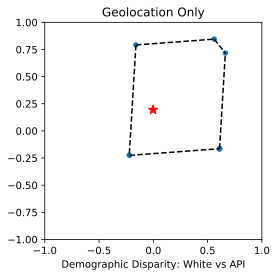

In [313]:
fig = plt.figure()
ax = fig.add_subplot('111', aspect='equal') 
plt.plot(truth[0], truth[1], 'r*', markersize = 10)

xlim, ylim = (-1, 1), (-1, 1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("Geolocation Only")

plt.xlabel("Demographic Disparity: White vs API")
# plt.ylabel("Demographic Disparity: White vs Black")

temp = disparity_county['1']
ch = ConvexHull(temp)
plt.scatter(temp[:, 0], temp[:, 1], s = 20, label= 'county')
for simplex in ch.simplices:
    plt.plot(temp[simplex, 0],temp[simplex, 1], 'k--')
    
fig.savefig("writing/slides_figure/hmda_county.pdf", bbox_inches='tight')

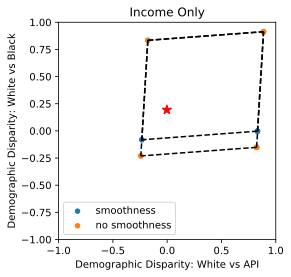

In [314]:
fig = plt.figure()
ax = fig.add_subplot('111', aspect='equal') 
plt.plot(truth[0], truth[1], 'r*', markersize = 10)

xlim, ylim = (-1, 1), (-1, 1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("Income Only")

plt.xlabel("Demographic Disparity: White vs API")
plt.ylabel("Demographic Disparity: White vs Black")

temp = disparity_income['0.0006']
ch = ConvexHull(temp)
plt.scatter(temp[:, 0], temp[:, 1], s = 20, label= 'smoothness')
for simplex in ch.simplices:
    plt.plot(temp[simplex, 0],temp[simplex, 1], 'k--')
    
temp = disparity_income['0.0012']
ch = ConvexHull(temp)
plt.scatter(temp[:, 0], temp[:, 1], s = 20, label= 'no smoothness')
for simplex in ch.simplices:
    plt.plot(temp[simplex, 0],temp[simplex, 1], 'k--')
    
plt.legend()

fig.savefig("writing/slides_figure/hmda_income.pdf", bbox_inches='tight')

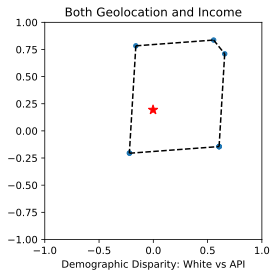

In [316]:
fig = plt.figure()
ax = fig.add_subplot('111', aspect='equal') 
plt.plot(truth[0], truth[1], 'r*', markersize = 10)

xlim, ylim = (-1, 1), (-1, 1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("Both Geolocation and Income")

plt.xlabel("Demographic Disparity: White vs API")
plt.ylabel("Demographic Disparity: White vs Black")

temp = disparity_both['0.009000000000000001']
ch = ConvexHull(temp)
plt.scatter(temp[:, 0], temp[:, 1], s = 20, label= 'county + income')
for simplex in ch.simplices:
    plt.plot(temp[simplex, 0],temp[simplex, 1], 'k--')
    
fig.savefig("writing/slides_figure/hmda_both.pdf", bbox_inches='tight')